In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

In [2]:
C = 3E8


In [3]:
def beta(v, c=1):
    return v/c

def gamma(v, c=1):
    return 1/np.sqrt(1-np.square(beta(v, c)))

def norm(a):
    return a/np.linalg.norm(a)

def split_gaussian(x, mu, sig_left, sig_right):
    sig = np.empty_like(x)
    sig[x < mu] = 1/sig_left
    sig[x >= mu] = 1/sig_right
        
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

In [4]:
def receiver_freq(source_freq, source_pos, source_vel, c=1):
    return (c * source_freq) / (c - np.dot(norm(source_pos), source_vel))

In [5]:
Gamma = 0.80
IntensityMax = 255

def wavelength_to_rgb(wavelength):
    wavelength = np.atleast_1d(wavelength)
    r = np.zeros_like(wavelength)
    g = np.zeros_like(wavelength)
    b = np.zeros_like(wavelength)
    factor = np.zeros_like(wavelength)
    
    r[np.where(np.logical_and(380<=wavelength, wavelength<440))] = -(wavelength[np.where(np.logical_and(380<=wavelength, wavelength<440))] - 440) / (440 - 380)
    g[np.where(np.logical_and(380<=wavelength, wavelength<440))] = 0.0
    b[np.where(np.logical_and(380<=wavelength, wavelength<440))] = 1.0
    
    r[np.where(np.logical_and(440<=wavelength, wavelength<490))] = 0.0
    g[np.where(np.logical_and(440<=wavelength, wavelength<490))] = (wavelength[np.where(np.logical_and(440<=wavelength, wavelength<490))] - 440) / (490 - 440)
    b[np.where(np.logical_and(440<=wavelength, wavelength<490))] = 1.0
    
    r[np.where(np.logical_and(490<=wavelength, wavelength<510))] = 0.0
    g[np.where(np.logical_and(490<=wavelength, wavelength<510))] = 1.0
    b[np.where(np.logical_and(490<=wavelength, wavelength<510))] = -(wavelength[np.where(np.logical_and(490<=wavelength, wavelength<510))] - 510) / (510 - 490)
    
    r[np.where(np.logical_and(510<=wavelength, wavelength<580))] = (wavelength[np.where(np.logical_and(510<=wavelength, wavelength<580))] - 510) / (580 - 510)
    g[np.where(np.logical_and(510<=wavelength, wavelength<580))] = 1.0
    b[np.where(np.logical_and(510<=wavelength, wavelength<580))] = 0.0
    
    r[np.where(np.logical_and(580<=wavelength, wavelength<645))] = 1.0
    g[np.where(np.logical_and(580<=wavelength, wavelength<645))] = -(wavelength[np.where(np.logical_and(580<=wavelength, wavelength<645))]  - 645) / (645 - 580)
    b[np.where(np.logical_and(580<=wavelength, wavelength<645))] = 0.0
    
    r[np.where(np.logical_and(645<=wavelength, wavelength<781))] = 1.0
    g[np.where(np.logical_and(645<=wavelength, wavelength<781))] = 0.0
    b[np.where(np.logical_and(645<=wavelength, wavelength<781))] = 0.0
    
    factor[np.where(np.logical_and(380<=wavelength, wavelength<420))] = 0.3 + 0.7 * (wavelength[np.where(np.logical_and(380<=wavelength, wavelength<420))] - 380) / (420 - 380)
    factor[np.where(np.logical_and(420<=wavelength, wavelength<701))] = 1.0
    factor[np.where(np.logical_and(701<=wavelength, wavelength<781))] = 0.3 + 0.7 * (780 - wavelength[np.where(np.logical_and(701<=wavelength, wavelength<781))]) / (780 - 700)
        
    return (np.floor(IntensityMax * np.power(r * factor, Gamma)),
            np.floor(IntensityMax * np.power(g * factor, Gamma)), 
            np.floor(IntensityMax * np.power(b * factor, Gamma)))




In [6]:
wavelengths = np.linspace(300, 800, 500)
rgbs = wavelength_to_rgb(wavelengths)
cmap_wavelength = np.transpose(rgbs)/256


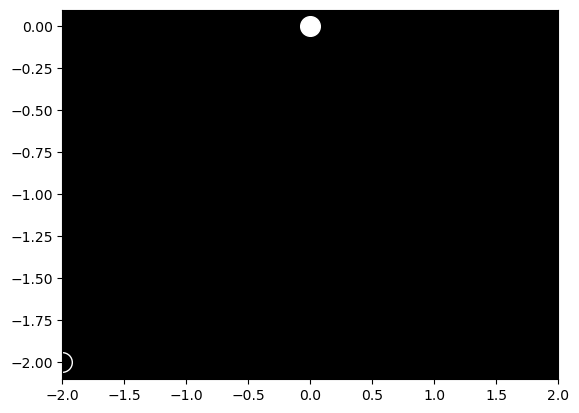

In [7]:
dt = 1/60
starting_freq = 6E14

s_pos = np.array([-2, -2])
s_vel = np.array(([0.8, 0]))

starting_pos = s_pos.copy()

# plt.close(fig)
fig, ax = plt.subplots()

def get_c_val(source_freq, source_pos, source_vel):
    rgbs = wavelength_to_rgb((C/receiver_freq(source_freq, source_pos, source_vel))*1E9)
    return np.transpose(rgbs)/256

scat = ax.scatter((s_pos[0], ), (s_pos[1], ), c=get_c_val(starting_freq, s_pos, s_vel), s=200, linewidth=1, edgecolor='white')
me = ax.scatter((0, ), (0, ), c="white", s=200, linewidth=1, edgecolor='white')
ax.set(facecolor="black")
ax.set_xlim((-abs(s_pos[0]), abs(s_pos[0])))

def update(frame):
    global s_pos
    cur_pos = s_pos + s_vel * dt * frame
    scat.set_offsets((cur_pos, ))
    scat.set_facecolor(get_c_val(starting_freq, cur_pos, s_vel))
    
    return (scat, )

frame_count = int(2*abs(starting_pos[0])/s_vel[0] * 60)
ani = mpl.animation.FuncAnimation(fig=fig, func=update, frames=frame_count, interval=int(dt*1000), repeat=True)
HTML(ani.to_html5_video())
# plt.close(fig)